In [1]:
#The goal of this notebook is to calculate the energy from the csv 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/brantran/power_modeling/accel-sim-framework'

In [3]:
#Step one is to read in the csvs
#Oh dear, we have a frequency of 46c (which is 1132 in hex)
#Alright, so we know that we are sampling every 500 cycles
#Frequency would then be defined as cycles per second
def convert_to_decimal(val):
    try:
        # Attempt to convert directly to integer (for normal numeric values)
        return int(val)
    except ValueError:
        try:
            # If the conversion fails, assume it's hexadecimal and convert
            return int(val, 16)
        except ValueError:
            # Handle any other unexpected values
            return None


accelwattch_dir = os.path.join('logs_accelwattch','100iter_perkernel_sample_500cycle')
accelwattch_dir = "accelwattch_parsed_output"
kernel_info_list = []
bad_freq_list = []
for file in os.listdir(accelwattch_dir): #[:5]:
    file_path = os.path.join(accelwattch_dir,file)
    df = pd.read_csv(file_path)    
    # Apply the function to the 'core_clock_freq_mhz' column
    df['core_clock_freq_mhz'] = df['core_clock_freq_mhz'].apply(convert_to_decimal)
    # The last index is the cycle that can be solely attributed to the exit,
    #  (there is no static power), so we ignore it
    df.drop(df.index[-1], inplace=True)
    #Parse the file names
#     benchmark,details = file.split('.accelsim-commit-5b72768d4f64cb46b91dc9556dbe04298cdff5d8_modified_5.0_processed_')
    benchmark,details = file.split('.processed_')
    opcode,config = benchmark.split('-')
#     print(benchmark,details)
    kernel,cycle_count,instr_count = details.strip('.csv').split('_')
#     print(opcode,config,kernel,cycle_count,instr_count)

    core_clock = list(df.core_clock_freq_mhz)
    for val in core_clock:
        try:
            good_val = int(val)
        except:
            if benchmark+val not in bad_freq_list:
                print(benchmark,val)
                bad_freq_list.append(benchmark+val)

    #Append all the information to the list
    kernel_info_list.append((opcode,config,kernel,
                             int(cycle_count.strip('cycle')),int(instr_count.strip('instr')),
                             df))
            
#     break
kernel_info_list.sort(key=lambda x: x[0])
# list(df.core_clock_freq_mhz)
# kernel_info_list
kernel_info_list[-1][5]

,const_power_W,static_power_W,technology_nm,core_clock_freq_mhz,area,peak_power_W,total_leakage_W,peak_dynamic_W,subthreshold_leakage_W,gate_leakage_W,runtime_dynamic_W
0,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,3.60112
1,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022
2,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,17.34490
3,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022
4,32.325223,37.386998,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,15.50110
...,...,...,...,...,...,...,...,...,...,...,...
201,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022
202,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022
203,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022
204,32.325223,34.794914,23,520,40.6137,7.42519,0.693847,6.73134,0.599781,0.094066,0.55022


In [4]:
# #SANITY CHECKING
# # Question: 500 cycle sample * num_samples ~ total_cycles?
# # Answer: For kernel_1 this is relatively true
# #     for all other kernels the sampling rate appears to be 200-400
# cycles_per_sample = 500
# for kernel_info in kernel_info_list:
#     benchmark,kernel,cycle_count,instr_count,df = kernel_info
# #     print(f"""{benchmark}_{kernel} sampled {len(df)}
# #     Calculated total={len(df)*cycles_per_sample}
# #     Expected total  ={cycle_count}
# #     Reversed sample frequency = {int(cycle_count/len(df))}
# #     """)

# # Dictionary to calculate number of cycles per sample for each kernel
# reversed_freq_by_kernel_dict = {}
# reversed_freq_dict = {}
# # Process each kernel_info in the list
# for benchmark, kernel, cycle_count, instr_count, df in kernel_info_list:
#     reversed_sample_freq = int(cycle_count / len(df))
    
#     # Collect the reversed sample frequency for the kernel
#     if kernel not in reversed_freq_by_kernel_dict:
#         reversed_freq_by_kernel_dict[kernel] = []
#     reversed_freq_by_kernel_dict[kernel].append(reversed_sample_freq)
#     reversed_freq_dict[benchmark+kernel]=reversed_sample_freq
    

# # Plot histograms for each kernel group
# for kernel, freqs in reversed_freq_by_kernel_dict.items():
#     plt.figure(figsize=(8, 6))
#     sns.histplot(freqs)
#     plt.title(f'Histogram of Reversed Sample Frequencies for {kernel}')
#     plt.xlim(0,525)
#     plt.xlabel('Reversed Sample Frequency')
#     plt.ylabel('Count')
#     plt.show()

In [5]:
# #SANITY CHECK:
# # Question: Are the simulated instructions matched with actual execution?
# # Answer: For setup kernels okay, but for actual kernels we are an order of magnitude off
# #     We are simulating way more instructions than were actually executed
# #     Does the simulated count include predicated instructions
# !python3 ../flop_counting/parse_ncu_report.py ../flop_counting/ncu_reports/ncu_report_accelwattch_for_matt_100/

In [6]:
# instr_data = pd.read_csv('../flop_counting/ncu_reports/ncu_report_accelwattch_for_matt_100/all_benchmark_sass__inst_executed_per_opcode_with_modifier_all.csv')
# instr_data.set_index('benchmark',inplace=True)
# instr_data['total'] = instr_data.sum(axis=1)
# ground_truth_instr_count_dict = instr_data['total'].to_dict()

# for benchmark,kernel,cycle_count,instr_count,df in kernel_info_list:
#     key = f"{benchmark}_{kernel}".replace('-','_')
#     if key in ground_truth_instr_count_dict:
#         ground_truth = ground_truth_instr_count_dict[key]
#         print(f"""{key}
#         Simulated:    {instr_count}
#         Ground Truth: {ground_truth}
#         MAPE:         {100*abs(instr_count - ground_truth)/ground_truth:2f}%
#         """)
# #     else:
# #         print("Not in dict", key)
# #     print(f"""{benchmark}_{kernel} sampled {len(df)}
# #     Calculated total={len(df)*cycles_per_sample}
# #     Expected total  ={cycle_count}
# #     Reversed sample frequency = {int(cycle_count/len(df))}
# #     """)

In [7]:
test_df = kernel_info_list[0][5]
test_df.columns

Index(['const_power_W', 'static_power_W', 'technology_nm',
       'core_clock_freq_mhz', 'area', 'peak_power_W', 'total_leakage_W',
       'peak_dynamic_W', 'subthreshold_leakage_W', 'gate_leakage_W',
       'runtime_dynamic_W'],
      dtype='object')

['BAR_SYNC', 'BAR_SYNC', 'BMOV_32_CLEAR', 'BMOV_32_CLEAR', 'BRA', 'BRA', 'BREAK', 'BREAK', 'BSSY', 'BSSY', 'BSYNC', 'BSYNC', 'CALL_REL_NOINC', 'CALL_REL_NOINC', 'DEPBAR_LE', 'DEPBAR_LE', 'EXIT', 'EXIT', 'F2F_F32_F64', 'F2F_F32_F64', 'F2F_F64_F32', 'F2F_F64_F32', 'FADD', 'FADD', 'HMMA_884_F16_F16_STEP0', 'HMMA_884_F16_F16_STEP0', 'HMMA_884_F16_F16_STEP1', 'HMMA_884_F16_F16_STEP1', 'HMMA_884_F32_F32_STEP0', 'HMMA_884_F32_F32_STEP0', 'HMMA_884_F32_F32_STEP1', 'HMMA_884_F32_F32_STEP1', 'LDC', 'LDC', 'LDG_E_SYS', 'LDG_E_SYS', 'LDS_U', 'LDS_U', 'LOP3_LUT', 'LOP3_LUT', 'MUFU.EX2', 'MUFU.EX2', 'MUFU_RCP', 'MUFU_RCP', 'MUFU_RCP64H', 'MUFU_RCP64H', 'NOP', 'NOP', 'PLOP3_LUT', 'PLOP3_LUT', 'RET_REL_NODEC', 'RET_REL_NODEC', 'S2R', 'S2R', 'STG_E_SYS', 'STG_E_SYS', 'STS', 'STS', 'TLD', 'TLD']


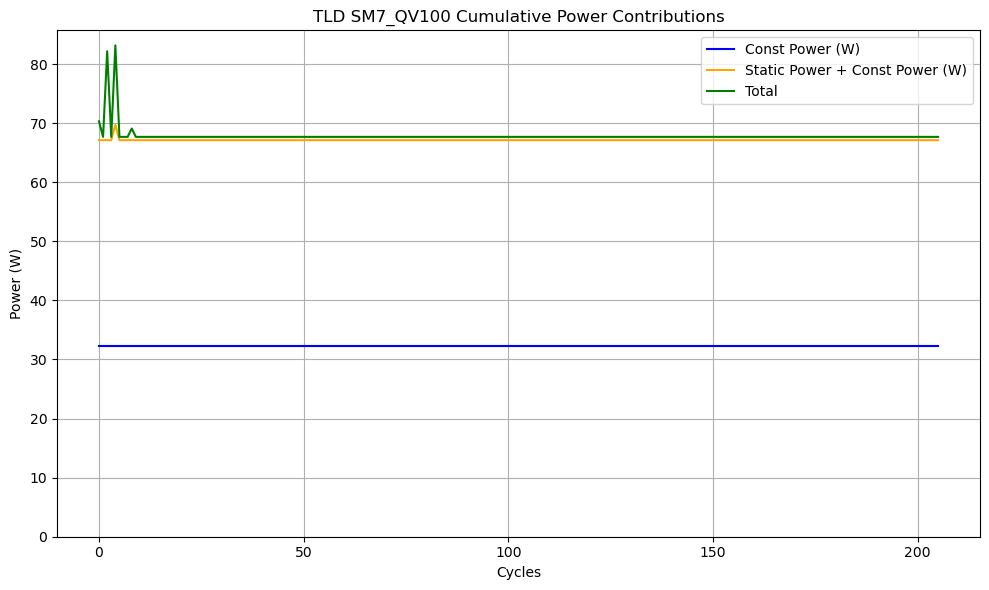

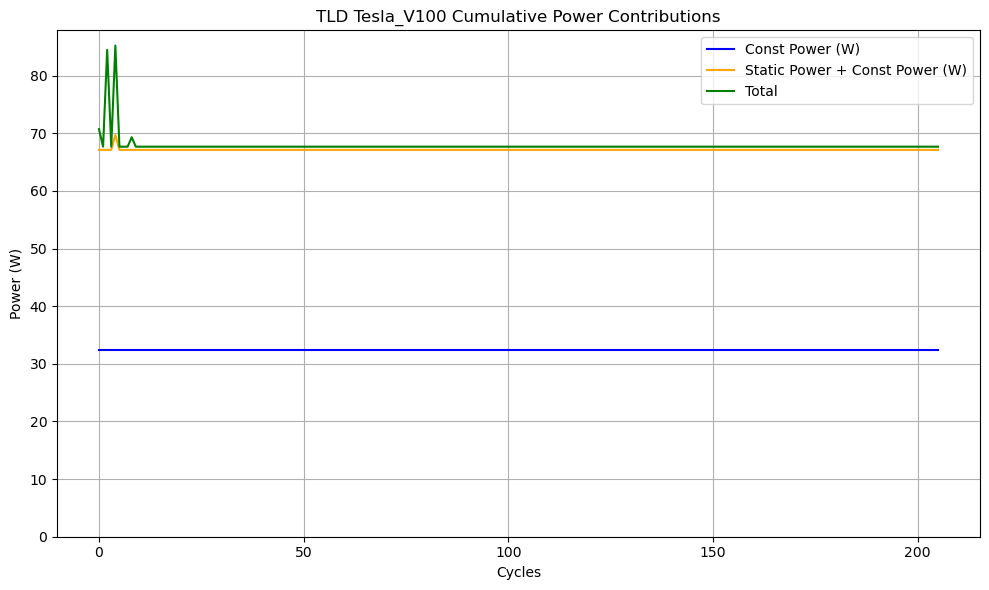

,opcode,config,total_energy_J,active_energy_J,dyn_energy_J,num_instr,cycles
58,TLD,SM7_QV100,0.000012,0.000006,1.262522e-07,5120,206
59,TLD,Tesla_V100,0.000027,0.000014,2.840525e-07,5120,206


In [13]:
# Calculate the total energy of running accelwattch
# We use the static power of 32W
# We integrate our power samples over derived time (from frequency and cycles per sample)
# Since we are simulating 100 iters, runtime is very short, so we expect low energy
energy_dict = {}
plotting_dict = {}
#Print the opcodes that we have
print([item[0] for item in kernel_info_list])
target_opcode = 'TLD'

# constant_power=32.32522272

for opcode, config, kernel, cycle_count, instr_count, df in kernel_info_list:
    if target_opcode in opcode:
        # Calculate cumulative power contributions
        df['const_power_cumulative'] = df['const_power_W']
        df['static_power_cumulative'] = df['const_power_W'] + df['static_power_W']
        df['runtime_dynamic_cumulative'] = df['static_power_cumulative'] + df['runtime_dynamic_W']

        # Plot the lines
        plt.figure(figsize=(10, 6))
        plt.plot(df.index, df['const_power_cumulative'], label='Const Power (W)', color='blue')
        plt.plot(df.index, df['static_power_cumulative'], label='Static Power + Const Power (W)', color='orange')
        plt.plot(df.index, df['runtime_dynamic_cumulative'], label='Total', color='green')

        # Add labels, legend, and title
        plt.xlabel("Cycles")
        plt.ylabel('Power (W)')
        plt.title(f'{opcode} {config} Cumulative Power Contributions')
        plt.ylim(0)
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.tight_layout()
        plt.show()
    df['active_power'] = df['static_power_W'] + df['runtime_dynamic_W']
    df['total_power'] = df['const_power_W'] + df['static_power_W'] + df['runtime_dynamic_W']
    # Calculate time step based on the frequency
    df['cycles_per_second'] = df['core_clock_freq_mhz'] * 10**6 #Convert to Hz
    df['cycle_duration'] = df['cycles_per_second'].rdiv(1) #Hz to seconds
#     If we wait more cycles per sample use this
#     df['sample_duration'] = df['cycle_duration'] * reversed_freq_dict[benchmark+kernel]    
    dyn_energy = np.trapz(df['runtime_dynamic_W'], x=df['cycle_duration'].cumsum())
    active_energy = np.trapz(df['active_power'], x=df['cycle_duration'].cumsum())
    total_energy = np.trapz(df['total_power'], x=df['cycle_duration'].cumsum())
    energy_dict[(opcode,config)]=(total_energy,active_energy,dyn_energy,instr_count,len(df))
#     print(opcode,config)
#     print(df[['static_power_W','runtime_dynamic_W','active_power','const_power_W','total_power']])
#     print(total_energy,active_energy,dyn_energy)
# Unpack the tuples into separate lists
data = [(benchmark[0],benchmark[1], *values) for benchmark, values in energy_dict.items()]

# Create a DataFrame
energy_df = pd.DataFrame(data, columns=['opcode', 'config', 'total_energy_J', 'active_energy_J', 'dyn_energy_J',  'num_instr', 'cycles'])
# energy_df.to_csv(f'{target_dir}_energy.csv',index=False)
energy_df[energy_df['opcode'].str.contains(target_opcode)]

In [12]:
#Now that we have the energies calculation, we need to get energy per op values
#Note that for all num_instr, we are factoring in two instructions the Target + Exit. So we can either do a zero sum thing, or we can do 
# Step 1: Create energy_per_op columns
#"energy_per_opcode_otherbuckets_energy_dynamic_median.csv"
energy_column_name_dict = {'total_energy_J_per_op': 'measured_energy_median',
                           'active_energy_J_per_op': 'energy_active_median',
                           'dyn_energy_J_per_op': 'energy_dynamic_median',
                          }
for col in ['total_energy_J', 'dyn_energy_J', 'active_energy_J']:
    energy_per_op_col = f"{col}_per_op"
    energy_df[energy_per_op_col] = (energy_df[col] / (energy_df['num_instr'] / 2)) * 1e12

# Step 2: Write to CSV files
# Group by `config`
grouped = energy_df.groupby('config')

for config, group in grouped:
    for energy_per_op_col in ['total_energy_J_per_op', 'dyn_energy_J_per_op', 'active_energy_J_per_op']:
        # Select relevant columns
        output_df = group[['opcode', energy_per_op_col]].copy()
        output_df['opcode'] = output_df['opcode'].str.replace("_", ".")
        # Generate file name
        file_name = f"energy_per_opcode_otherbuckets_{energy_column_name_dict[energy_per_op_col]}_{config}.csv"

        # Write to CSV
        output_df.to_csv(file_name, header=False, index=False)
        print(f"Written: {file_name}")



Written: energy_per_opcode_otherbuckets_measured_energy_median_SM7_QV100.csv
Written: energy_per_opcode_otherbuckets_energy_dynamic_median_SM7_QV100.csv
Written: energy_per_opcode_otherbuckets_energy_active_median_SM7_QV100.csv
Written: energy_per_opcode_otherbuckets_measured_energy_median_Tesla_V100.csv
Written: energy_per_opcode_otherbuckets_energy_dynamic_median_Tesla_V100.csv
Written: energy_per_opcode_otherbuckets_energy_active_median_Tesla_V100.csv


In [ ]:
#This would be trying to write out the data as a csv
#Holding off for now

# target_dirs = ['100iter_sample_per_500cycle','10iter_processed']
# total_df = None
# for target_dir in target_dirs:
#     target_file = f'{target_dir}_energy.csv'
#     if total_df is None:
#         total_df = pd.read_csv(target_file)
#     else:
#         new_df = pd.read_csv(target_file)
#         total_df = total_df.merge(new_df, on="benchmark", suffixes=('', target_dir.split("iter")[0]))
# total_df.to_csv(f'accelwattch_energy.csv',index=False)

In [ ]:
plotting_dict.keys()

In [ ]:
#Let's just plot the power profile
target_benchmark = 'TENSOR-100'
for target_benchmark in plotting_dict:
    data = plotting_dict[target_benchmark]

    plt.plot(data)
    plt.title(f'{target_benchmark} microbenchmark')
    plt.xlabel('Samples')
    plt.ylabel('Predicted Power (W)')
    plt.ylim(0,300)
    plt.show()
    print(max(data))

In [ ]:
#Now for the energy per instruction handwave!

for benchmark,kernel,cycle_count,instr_count,df in kernel_info_list:
    total_energy,dyn_energy,static_energy,_= energy_dict[benchmark]
    key = f"{benchmark}_{kernel}".replace('-','_')
    #we only care about the benchmarks that are in the ground truth
    if key in ground_truth_instr_count_dict:
        ground_truth = ground_truth_instr_count_dict[key]
        #Now we calculated the energy per opcode
        #How exactly do I want to do this?
        #Is it access based? Is it something else?
        #I don't really know
